<a href="https://colab.research.google.com/github/iamviji/project/blob/master/Snap/CNNAE_5x20_8_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense,  Reshape, GaussianNoise, BatchNormalization, Conv1D, Activation, Lambda, Flatten

from tensorflow.keras import Model
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical





input_block_length = 5
num_of_input_block = 20
input_message_length = input_block_length * num_of_input_block 
encoder_output_length = 8
channel_size = 5  #per block


NUM_OF_INPUT_MESSAGE = 1000*10
NUM_OF_INPUT_MESSAGE_TEST = 1000
SNR_STEP_SIZE = .5

SNR_BEGIN = 0
SNR_END = 10

TRAIN_SNR_BEGIN = 3
TRAIN_SNR_END = 6

train_batch_size = 1000

bler_per_iter_uncoded_commpy_psk_2 = [0.521, 0.473, 0.436, 0.37,  0.304, 0.259, 0.187, 0.138, 0.098, 0.098, 0.052, 0.028, 0.012, 0.011, 0.009, 0.002, 0.0,  0.001, 0.,    0.0]
bler_per_iter_uncoded_itpp_psk_2 = [0.518, 0.478, 0.415, 0.355, 0.305, 0.227, 0.177, 0.149, 0.11,  0.075, 0.055, 0.023, 0.014, 0.014, 0.015, 0.001, 0.003, 0.001, 0.,    0. ]
bler_per_iter_uncoded_commpy_psk_4 = [0.815, 0.793, 0.75,  0.714, 0.64,  0.639, 0.526, 0.49,  0.433, 0.371, 0.335, 0.236, 0.204, 0.154, 0.129, 0.08,  0.063, 0.046, 0.023, 0.018]
bler_per_iter_uncoded_itpp_psk_4 = [0.814, 0.767, 0.729, 0.702, 0.66,  0.616, 0.563, 0.511, 0.442, 0.4,   0.294, 0.277, 0.228, 0.17,  0.114, 0.087, 0.05,  0.037, 0.022, 0.017]
bler_per_iter_ldpc_itpp_psk_4 = [0.584, 0.488, 0.404, 0.332, 0.218, 0.151, 0.097, 0.058, 0.041, 0.024, 0.007, 0.004, 0.002, 0.001, 0.001, 0.,    0.,    0.,    0.,    0.,   ]
bler_per_iter_ham_itpp_psk_4 = [0.51, 0.479, 0.419, 0.333, 0.313, 0.247, 0.212, 0.132, 0.114, 0.093, 0.042, 0.027, 0.024, 0.016, 0.006, 0.005, 0.003, 0.002, 0.,    0.  ]
bler_per_iter_uncoded_itpp_psk_8 = [0.921, 0.917, 0.912, 0.867, 0.86,  0.857, 0.826, 0.808, 0.77,  0.737, 0.704, 0.657, 0.608, 0.6,   0.547, 0.487, 0.426, 0.361, 0.323, 0.293]
bler_per_iter_uncoded_commpy_psk_8 = [0.923, 0.912, 0.891, 0.888, 0.874, 0.851, 0.804, 0.779, 0.758, 0.736, 0.715, 0.643, 0.614, 0.557, 0.542, 0.503, 0.431, 0.386, 0.331, 0.289]

ber_per_iter_uncoded_itpp_psk_2 = [0.07933333, 0.067, 0.058, 0.04811111, 0.039, 0.02911111, 0.02211111, 0.01833333, 0.01266667, 0.00866667, 0.00622222, 0.00255556, 0.00166667, 0.00155556, 0.00166667, 0.00011111, 0.00033333, 0.00011111, 0., 0.]
ber_per_iter_uncoded_commpy_psk_2 = [0.07955556, 0.07055556, 0.05344444, 0.04477778, 0.03644444, 0.02888889, 0.02055556, 0.01955556, 0.01033333, 0.00855556, 0.00522222, 0.004, 0.00188889, 0.00155556, 0.00055556, 0.00066667, 0.00022222, 0.00011111, 0., 0.]
ber_per_iter_uncoded_itpp_psk_4 = [0.1559, 0.1421, 0.1248, 0.1137, 0.1031, 0.0924, 0.0802, 0.0684, 0.055,  0.0499, 0.0348, 0.0336, 0.0257, 0.0185, 0.0121, 0.0092, 0.0054, 0.0037, 0.0022, 0.0017]
ber_per_iter_uncoded_commpy_psk_4 = [0.2137, 0.1943, 0.1773, 0.1624, 0.1473, 0.1355, 0.1105, 0.0984, 0.0873, 0.0686, 0.0573, 0.0454, 0.0356, 0.024,  0.0214, 0.0142, 0.0111, 0.0055, 0.0038, 0.002]
ber_per_iter_uncoded_itpp_psk_8 = [0.24566667, 0.23411111, 0.21455556, 0.19888889, 0.188, 0.184, 0.16355556, 0.15655556, 0.13777778, 0.12966667, 0.115, 0.10622222, 0.09211111, 0.088, 0.07622222, 0.06855556, 0.05677778, 0.04755556, 0.04188889, 0.03577778]
ber_per_iter_uncoded_commpy_psk_8 = [0.32577778, 0.31533333, 0.30455556, 0.29644444, 0.27955556, 0.266, 0.24677778, 0.23411111, 0.22088889, 0.209,      0.19577778, 0.17544444, 0.15844444, 0.13966667, 0.13533333, 0.12077778, 0.10211111, 0.09066667, 0.07544444, 0.06355556]
ber_per_iter_ldpc_itpp_psk_4 = [1.25444444e-01, 1.19111111e-01, 9.48888889e-02, 7.54444444e-02, 5.50000000e-02, 3.86666667e-02, 2.51111111e-02, 1.53333333e-02, 1.04444444e-02, 1.22222222e-03, 2.88888889e-03, 0.00000000e+00, 1.11111111e-04, 3.33333333e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]

bler_per_iter_ldpc_50_100_itpp_psk_4 = [1., 1., 0.997, 0.989, 0.92,  0.697, 0.391, 0.123, 0.042, 0.011, 0.,    0.,  0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]
bler_per_iter_uncoded_100_itpp_psk_4 = [1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    0.997, 0.991, 0.97,  0.948, 0.924, 0.821, 0.74,  0.566, 0.444, 0.296, 0.211, 0.136]
bler_per_iter_uncoded_50_itpp_psk_4 = [1.,    1.,    1.,    1.,    .998,    .986,    .987,    0.974, 0.936, 0.912,  0.859, 0.785, 0.7, 0.602,  0.488, 0.329, 0.255, 0.168, 0.125, 0.061]
bler_per_iter_uncoded_50_itpp_psk_2 = [0.982, 0.964, 0.94,  0.9,   0.861, 0.773, 0.682, 0.565, 0.478, 0.359, 0.248, 0.169, 0.105, 0.074, 0.037, 0.016, 0.011, 0.003, 0.001, 0.   ]
bler_per_iter_uncoded_100_itpp_psk_2 = [0.999, 0.999, 0.995, 0.992, 0.975, 0.939, 0.898, 0.841, 0.72,  0.57,  0.44,  0.312, 0.209, 0.131, 0.071, 0.036, 0.017, 0.013, 0.003, 0.002]

ber_per_iter_ldpc_50_100_itpp_psk_4 = [0.21282, 0.20112, 0.18674, 0.16894, 0.15726, 0.14026, 0.1274, 0.11118, 0.0886,
 0.06074, 0.03002, 0.01486, 0.00372, 0.0003 , 0.     , 0.    , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.    , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.    , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.    , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.    , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.    , 0.     , 0.,
 0.     ] 
ber_per_iter_uncoded_50_itpp_psk_2 = [1.2920e-01, 1.1560e-01, 1.0574e-01, 9.3500e-02, 8.1340e-02, 6.6180e-02,
 5.7260e-02, 4.7700e-02, 3.8560e-02, 2.9580e-02, 2.3500e-02, 1.6280e-02,
 1.2500e-02, 8.5000e-03, 6.5200e-03, 3.8000e-03, 2.3800e-03, 1.2600e-03,
 9.0000e-04, 4.2000e-04, 8.0000e-05, 8.0000e-05, 4.0000e-05, 4.0000e-05,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ber_per_iter_uncoded_100_itpp_psk_2 = [1.3108e-01, 1.1509e-01, 1.0292e-01, 9.0680e-02, 7.8550e-02, 6.6490e-02,
 5.5550e-02, 4.6650e-02, 3.7450e-02, 2.9480e-02, 2.2790e-02, 1.8000e-02,
 1.2360e-02, 8.4600e-03, 6.1900e-03, 4.0100e-03, 2.6000e-03, 1.5000e-03,
 7.7000e-04, 4.9000e-04, 2.6000e-04, 5.0000e-05, 5.0000e-05, 2.0000e-05,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]


bler_per_iter_ldpc_100_200_itpp_psk_4 = [1.   , 1., 1., 1., 1., 1., 1., 1., 0.984, 0.8, 0.338, 0.077,
 0.006, 0., 0., 0., 0., 0., 0., 0., 0.   , 0. , 0.   , 0.,
 0.   , 0., 0., 0., 0., 0., 0., 0., 0.   , 0. , 0.   , 0.,
 0.   , 0., 0., 0., 0., 0., 0., 0., 0.   , 0. , 0.   , 0.,
 0.   , 0., 0., 0., 0., 0., 0., 0., 0.   , 0. , 0.   , 0.,
 0.   , 0., 0., 0. ]
ber_per_iter_ldpc_100_200_itpp_psk_4 = [0.21407, 0.19966, 0.18519, 0.17217, 0.15746, 0.14123, 0.12889, 0.11378, 0.092,
 0.06216, 0.02413, 0.00589, 0.00051, 0.     , 0.     , 0.     , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.,
 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.,
 0.     ]


import numpy as np #for numerical computing
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
import math
#ref : https://core.ac.uk/download/pdf/235049678.pdf
EbN0dBs = np.arange(start=0,stop = 10.5, step = .5)
PSK_2_BER_theory = 0.5*erfc(np.sqrt(10**(EbN0dBs/10)))
M=4
#QAM_BER_theory = 2*(1-np.sqrt(1/M))*erfc(np.sqrt(10**(EbN0dBs/10)))
QAM_BER_theory = erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
PSK_4_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
M=8
PSK_8_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
QAM_8_BER_theory = 2*erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
M=16
PSK_16_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
#QAM_16_BER_theory = 2*erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
QAM_16_BER_theory = (3.0/2)*erfc(np.sqrt((4.0/10))*np.sqrt(10**(EbN0dBs/10)))
                     #(3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))
M=32
PSK_32_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))


def Snr2Sigma(snr):
  sigma = (10 ** (- snr / 20))  #*(numpy.sqrt(2))
  return sigma


def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff



In [3]:
def conv_to_binary_from_decimal (decimal,input_message_size, input_message_length):
  binary = numpy.random.randint(1, size=(input_message_size,input_message_length))
  for i in range (input_message_size):
    bin = [int(x) for x in list('{0:0b}'.format(decimal[0][i]))]
    #print(bin)
    for j in range (len(bin)):
      offset = input_message_length - len(bin)
      #print ("x",offset)
      binary [i][j+offset] = bin [j]
  return binary

def conv_to_binary_from_decimal_block (input,num_of_input, num_of_block, block_size):
  binary = numpy.random.randint(1, size=(num_of_input,num_of_block, block_size))
  for i in range (num_of_input):
      for j in range (num_of_block):
        #print ("xxx", input[i][j])
        bin = [int(x) for x in list('{0:0b}'.format(input[i][j][0]))]
        #print(bin)
        for k in range (len(bin)):
          offset = block_size - len(bin)
          #print ("x",offset)
          binary [i][j][k+offset] = bin [k]
  return binary

def GetBerBler (input_message_binary1, input_message_binary2):
  diff = abs(input_message_binary1 - input_message_binary2)
  field_sum = numpy.sum (diff, axis=1)
  field_sum = numpy.reshape (field_sum, (-1,1))
  ber = numpy.sum(field_sum)/(input_message_binary1.shape[0]*input_message_binary1.shape[1])
  field_non_zero_count = numpy.count_nonzero(field_sum != 0, axis=1)
  bler = numpy.sum(field_non_zero_count)/field_non_zero_count.shape[0]
  return ber, bler

def get_onehot_ber_bler_of_model (snr_list, encoder, decoder, input_onehot, input_binary, num_of_input_msg, input_message_length, channel_size, verbose=1):
  bler_per_iter_dl_tensor  = numpy.array(())
  ber_per_iter_dl_tensor  = numpy.array(())
  channel_out = []
  encoded_message = encoder.predict(input_onehot)
  for snr in snr_list:
    total_bit_error = 0
    total_msg_error = 0    
    sigma = Snr2Sigma (snr)
    noised_message = encoded_message + numpy.random.normal(0, sigma, encoded_message.shape)
    for i in range (num_of_input_msg):
      noised_message[i] = encoded_message[i] + numpy.random.normal(0, sigma, [1,2*channel_size])
      channel_out.append(noised_message[i])
    decoded_message = decoder.predict(noised_message)
    decoded_message_decimal = []
    decoded_message_decimal.append(numpy.argmax(decoded_message, axis=1))
    decoded_message_binary = conv_to_binary_from_decimal (decoded_message_decimal, num_of_input_msg,  input_message_length)
    ber,bler = GetBerBler (input_binary, decoded_message_binary)
    print('SNR: {:04.3f}:-> BLER: {:03.3f} BER: {:03.3f}'.format(snr,bler,ber))
    bler_per_iter_dl_tensor = numpy.append(bler_per_iter_dl_tensor, bler)
    ber_per_iter_dl_tensor = numpy.append(ber_per_iter_dl_tensor, ber)
  return ber_per_iter_dl_tensor, bler_per_iter_dl_tensor, channel_out

def get_block_onehot_ber_bler_of_model (snr_list, encoder, decoder, input_onehot, input_decimal, num_of_input,num_of_input_block, input_block_length, channel_size, verbose=1):
  print ("get_block_onehot_ber_bler_of_model")
  print ("num_of_input:", num_of_input, " num_of_input_block:", num_of_input_block, " input_block_length:", input_block_length, "channel_size:", channel_size )
  bler_per_iter_dl_tensor  = numpy.array(())
  ber_per_iter_dl_tensor  = numpy.array(())
  channel_out = []
  encoded_message = encoder.predict(input_onehot)
  for snr in snr_list:

    total_bit_error = 0
    total_msg_error = 0    
    sigma = Snr2Sigma (snr)

    noised_message = encoded_message + numpy.random.normal(0, sigma, encoded_message.shape)

    for i in range (num_of_input):
      noised_message[i] = encoded_message[i] + numpy.random.normal(0, sigma, [1,2*channel_size])
      channel_out.append(noised_message[i])

    decoded_message = decoder.predict(noised_message)
    decoded_message = numpy.argmax(decoded_message, axis=2)
    decoded_message = numpy.reshape (decoded_message, (-1,decoded_message.shape[1],1 ))

    decoded_message_binary =  conv_to_binary_from_decimal_block (decoded_message, num_of_input, num_of_input_block, input_block_length)   
    input_message_binary =  conv_to_binary_from_decimal_block (input_decimal, num_of_input, num_of_input_block, input_block_length)   
    diff = abs(decoded_message_binary - input_message_binary)
    diff_sum = numpy.sum(np.sum (diff, axis=1), axis=1)
    block_error = numpy.count_nonzero(diff_sum!=0)
    bit_error = numpy.sum(diff_sum)
    total_msg_error = total_msg_error +block_error
    total_bit_error = total_bit_error + bit_error
    bler = float(total_msg_error)/(num_of_input)
    ber = float(total_bit_error)/(num_of_input*num_of_input_block*input_block_length)
    print('SNR: {:04.3f}:-> BLER: {:03.5f} BER: {:03.5f} '.format(snr,bler,ber))
    print ("total_bit_error:", total_bit_error)
    print ("total_msg_error:", total_msg_error)
    bler_per_iter_dl_tensor = numpy.append(bler_per_iter_dl_tensor, bler)
    ber_per_iter_dl_tensor = numpy.append(ber_per_iter_dl_tensor, ber)
  return ber_per_iter_dl_tensor, bler_per_iter_dl_tensor, channel_out

In [5]:
def PowerNormLayer(x):
    nx =  x / tf.sqrt(tf.reduce_mean(tf.square(x)))
    return nx

In [6]:
snr_std = Snr2Sigma(7.0)
num_filters = 2**encoder_output_length
print ("num_of_input_block", num_of_input_block)
print ("input_block_length", input_block_length)

input_message_x = Input(shape=(num_of_input_block, 2**input_block_length), name="inputs")

enc = Conv1D(filters=num_filters, strides=1, kernel_size=1, name='enc_1')(input_message_x)
enc = BatchNormalization(name='enc_2')(enc)
enc = Activation('elu', name='enc_3')(enc)

enc = Conv1D(filters=num_filters, strides=1, kernel_size=1, name='enc_4')(enc)
enc = BatchNormalization(name='enc_5')(enc)
enc = Activation('elu', name='ecn_6')(enc)

enc = Conv1D(filters=2 * channel_size, strides=1, kernel_size=1, name='ch_1')(enc)
enc = BatchNormalization(name='ch_2')(enc)
enc = Activation('linear', name='ch_3')(enc)
enc = Flatten()(enc)
encoder_out = Lambda(PowerNormLayer, name='PowerNorm')(enc)

encoder = Model(input_message_x, encoder_out, name ="Encoder")

awgn_channel = GaussianNoise(Snr2Sigma(snr_std),input_shape=(2*channel_size,), name = "AWGN_Layer")

encoded_input = Input(shape=(num_of_input_block*2*channel_size,))

reshaped_input = tf.reshape (encoded_input, (-1,num_of_input_block,2*channel_size))


dec = Conv1D(filters=num_filters, strides=1, kernel_size=1, name='dec_1')(reshaped_input)
dec = BatchNormalization(name='dec_2')(dec)
dec = Activation('elu', name='dec_3')(dec)

dec = Conv1D(filters=num_filters, strides=1, kernel_size=1, name='dec_4')(dec)
dec = BatchNormalization(name='dec_5')(dec)
dec = Activation('elu', name='dec_6')(dec)

model_output = Conv1D(filters=2 ** input_block_length, strides=1, kernel_size=1, name='d_10', activation='softmax')(dec)


decoder = Model(encoded_input, model_output, name="Decoder")

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))), name = "End2End_Model")


print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

num_of_input_block 20
input_block_length 5
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20, 32)]          0         
_________________________________________________________________
enc_1 (Conv1D)               (None, 20, 256)           8448      
_________________________________________________________________
enc_2 (BatchNormalization)   (None, 20, 256)           1024      
_________________________________________________________________
enc_3 (Activation)           (None, 20, 256)           0         
_________________________________________________________________
enc_4 (Conv1D)               (None, 20, 256)           65792     
_________________________________________________________________
enc_5 (BatchNormalization)   (None, 20, 256)           1024      
_________________________________________________________________
ecn_6 (Activatio

In [7]:
training_input_message = numpy.random.randint(2**input_block_length, size=(NUM_OF_INPUT_MESSAGE,num_of_input_block,1))
#print(training_input_message)
training_input_message_one_hot = to_categorical(y=training_input_message, num_classes=2**input_block_length)
#print(training_input_message_one_hot)

test_input_message = numpy.random.randint(2**input_block_length, size=(NUM_OF_INPUT_MESSAGE,num_of_input_block,1))
#print(test_input_message)
test_input_message_one_hot = to_categorical(y=test_input_message, num_classes=2**input_block_length)
#print(test_input_message_one_hot)


In [8]:
import keras
autoencoder.compile(optimizer=keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
training_history1 = dict ()
beginTime = time.clock()
for snr in (numpy.arange (TRAIN_SNR_BEGIN, TRAIN_SNR_END, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  snr_std = sigma
  print ("Training for SNR=", snr, " sigma=", sigma) 
  history = autoencoder.fit(training_input_message_one_hot, training_input_message,
                epochs=50,
                batch_size=train_batch_size,
                shuffle=False,
                validation_data=(test_input_message_one_hot, test_input_message))
  training_history1 [snr] = history

endTime = time.clock()
print('TotalTime: ' + str(endTime - beginTime) + ' s')

Training for SNR= 3.0  sigma= 0.7079457843841379
Epoch 1/50
10/10 [==============================] - 11s 1s/step - loss: 2.5871 - sparse_categorical_accuracy: 0.3648 - val_loss: 1.6917 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/50
10/10 [==============================] - 9s 948ms/step - loss: 0.8700 - sparse_categorical_accuracy: 0.7737 - val_loss: 0.8568 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - 9s 953ms/step - loss: 0.6454 - sparse_categorical_accuracy: 0.8125 - val_loss: 0.5183 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/50
10/10 [==============================] - 9s 952ms/step - loss: 0.5867 - sparse_categorical_accuracy: 0.8228 - val_loss: 0.3649 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 9s 953ms/step - loss: 0.5563 - sparse_categorical_accuracy: 0.8268 - val_loss: 0.2786 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 9

In [9]:
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
bler_per_iter_dl_tensor  = numpy.array(())
ber_batch_size = 1000
ber_iteration = int(NUM_OF_INPUT_MESSAGE/ber_batch_size)
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (ber_iteration):
    input_message_xx = training_input_message_one_hot [i:i+ber_batch_size]
    #print ("input", training_input_message[i:i+ber_batch_size])
    encoded_message = encoder.predict(training_input_message_one_hot[i:i+ber_batch_size])
    #print (encoded_message)
    noised_message = encoded_message + numpy.random.normal(0, sigma, encoded_message.shape)
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    decoded_message = numpy.argmax(decoded_message, axis=2)
    decoded_message = numpy.reshape (decoded_message, (-1,decoded_message.shape[1],1 ))
    #print ("decoded1:", decoded_message)
    #def conv_to_binary_from_decimal_block (input,num_of_input, num_of_block, block_size):
    decoded_message_binary =  conv_to_binary_from_decimal_block (decoded_message, ber_batch_size, num_of_input_block, input_block_length)   
    input_message_binary =  conv_to_binary_from_decimal_block (training_input_message [i:i+ber_batch_size], ber_batch_size, num_of_input_block, input_block_length)   
    #print ("decoded_message_binary:", decoded_message_binary)
    #print ("input_message_binary:", input_message_binary)
    diff = abs(decoded_message_binary - input_message_binary)
    #print ("diff", diff)
    diff_sum = numpy.sum(np.sum (diff, axis=1), axis=1)
    #print ("diff_sum", diff_sum)
    block_error = numpy.count_nonzero(diff_sum!=0)
    #print ("block_error:", block_error)
    bit_error = numpy.sum(diff_sum)
    #print ("bit_error",bit_error )
    total_msg_error = total_msg_error +block_error
    total_bit_error = total_bit_error + bit_error
    #print ("total_msg_error:", total_msg_error)
    #print ("total_bit_error", total_bit_error)
    i = i + ber_batch_size
  bler = float(total_msg_error)/(ber_iteration*ber_batch_size)

  ber = float(total_bit_error)/(ber_iteration*ber_batch_size*num_of_input_block*input_block_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.5f}  BER: {:03.5f}'.format(snr,bler,ber,total_time))
  print ("total:", total_bit_error)
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)  
  bler_per_iter_dl_tensor=numpy.append(bler_per_iter_dl_tensor ,bler)  
  

SNR: 0.000:
 ->BLER: 0.98550  BER: 0.09863
total: 98627
SNR: 0.500:
 ->BLER: 0.96370  BER: 0.07814
total: 78139
SNR: 1.000:
 ->BLER: 0.91440  BER: 0.05944
total: 59442
SNR: 1.500:
 ->BLER: 0.83380  BER: 0.04376
total: 43765
SNR: 2.000:
 ->BLER: 0.70250  BER: 0.03100
total: 30999
SNR: 2.500:
 ->BLER: 0.56590  BER: 0.02131
total: 21311
SNR: 3.000:
 ->BLER: 0.41030  BER: 0.01346
total: 13458
SNR: 3.500:
 ->BLER: 0.26770  BER: 0.00819
total: 8193
SNR: 4.000:
 ->BLER: 0.16090  BER: 0.00446
total: 4456
SNR: 4.500:
 ->BLER: 0.08690  BER: 0.00232
total: 2324
SNR: 5.000:
 ->BLER: 0.03920  BER: 0.00103
total: 1030
SNR: 5.500:
 ->BLER: 0.01720  BER: 0.00045
total: 454
SNR: 6.000:
 ->BLER: 0.00700  BER: 0.00018
total: 182
SNR: 6.500:
 ->BLER: 0.00270  BER: 0.00007
total: 69
SNR: 7.000:
 ->BLER: 0.00100  BER: 0.00002
total: 23
SNR: 7.500:
 ->BLER: 0.00030  BER: 0.00001
total: 9
SNR: 8.000:
 ->BLER: 0.00000  BER: 0.00000
total: 0
SNR: 8.500:
 ->BLER: 0.00000  BER: 0.00000
total: 0
SNR: 9.000:
 ->BLE

In [10]:
print (training_input_message_one_hot.shape)
ber_per_iter_dl_tensor1, bler_per_iter_dl_tensor1, channel_out1  = get_block_onehot_ber_bler_of_model (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE), 
          encoder, decoder, 
          training_input_message_one_hot, 
          training_input_message, 
          training_input_message_one_hot.shape[0], training_input_message_one_hot.shape[1],
          int(numpy.math.log2(training_input_message_one_hot.shape[2])),
          channel_size*num_of_input_block)
print (ber_per_iter_dl_tensor)
print (bler_per_iter_dl_tensor)

(10000, 20, 32)
get_block_onehot_ber_bler_of_model
num_of_input: 10000  num_of_input_block: 20  input_block_length: 5 channel_size: 100
SNR: 0.000:-> BLER: 0.98680 BER: 0.09861 
total_bit_error: 98612
total_msg_error: 9868
SNR: 0.500:-> BLER: 0.96130 BER: 0.07813 
total_bit_error: 78133
total_msg_error: 9613
SNR: 1.000:-> BLER: 0.91230 BER: 0.05970 
total_bit_error: 59702
total_msg_error: 9123
SNR: 1.500:-> BLER: 0.83150 BER: 0.04416 
total_bit_error: 44163
total_msg_error: 8315
SNR: 2.000:-> BLER: 0.71170 BER: 0.03101 
total_bit_error: 31014
total_msg_error: 7117
SNR: 2.500:-> BLER: 0.56940 BER: 0.02108 
total_bit_error: 21083
total_msg_error: 5694
SNR: 3.000:-> BLER: 0.41620 BER: 0.01389 
total_bit_error: 13892
total_msg_error: 4162
SNR: 3.500:-> BLER: 0.27510 BER: 0.00828 
total_bit_error: 8283
total_msg_error: 2751
SNR: 4.000:-> BLER: 0.15640 BER: 0.00437 
total_bit_error: 4369
total_msg_error: 1564
SNR: 4.500:-> BLER: 0.08390 BER: 0.00225 
total_bit_error: 2253
total_msg_error: 83

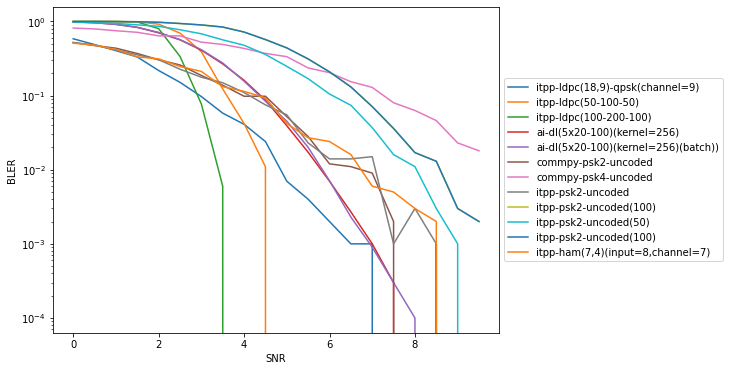

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_50_100_itpp_psk_4,'', label="itpp-ldpc(50-100-50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_100_200_itpp_psk_4[5:25],'', label="itpp-ldpc(100-200-100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_dl_tensor,'', label="ai-dl(5x20-100)(kernel=256)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_dl_tensor1,'', label="ai-dl(5x20-100)(kernel=256)(batch))") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_2,'', label="itpp-psk2-uncoded(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_2,'', label="itpp-psk2-uncoded(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_2,'', label="itpp-psk2-uncoded(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_xlabel('SNR')
#ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
#plt.legend ()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

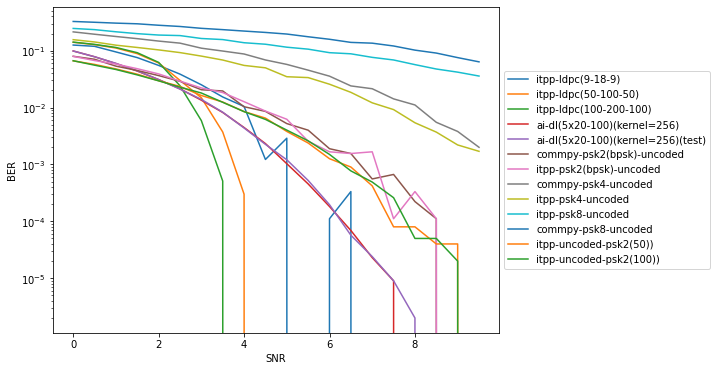

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(9-18-9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ldpc_50_100_itpp_psk_4[5:25],'', label="itpp-ldpc(50-100-50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ldpc_100_200_itpp_psk_4[5:25],'', label="itpp-ldpc(100-200-100)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(5x20-100)(kernel=256)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor1,'', label="ai-dl(5x20-100)(kernel=256)(test)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2(bpsk)-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2(bpsk)-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="itpp-psk4-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_8,'', label="itpp-psk8-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_8,'', label="commpy-psk8-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_itpp_psk_2[5:25],'', label="itpp-uncoded-psk2(50))") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_itpp_psk_2[5:25],'', label="itpp-uncoded-psk2(100))") # plot BER vs SNR
#ax1.semilogy(snrs,PSK_2_BER_theory[0:20],'', label="psk2-theory") # plot BER vs SNR
#ax1.semilogy(snrs,PSK_4_BER_theory[0:20],'', label="psk4-theory") # plot BER vs SNR
#ax1.semilogy(snrs,PSK_8_BER_theory[0:20],'', label="psk8-theory") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_xlabel('SNR')
#ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
#plt.legend ()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

14.142118
14.2253475
14.046293
0.17905426


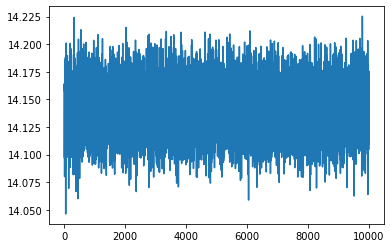

In [13]:
encoded_message = encoder.predict(training_input_message_one_hot)
x = numpy.sqrt(numpy.sum (numpy.square(encoded_message), axis=1))
plt.plot(x)
print (numpy.mean(x))
print (numpy.max(x))
print (numpy.min(x))
print (numpy.max(x) - numpy.min(x))

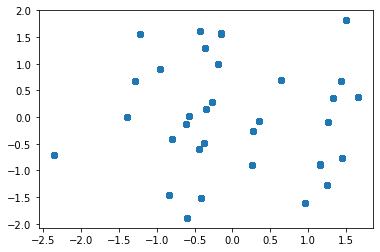

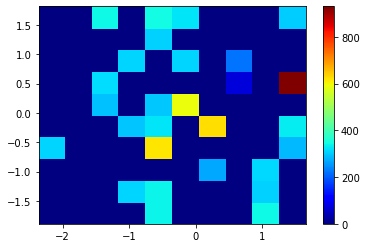

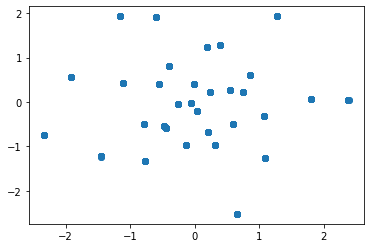

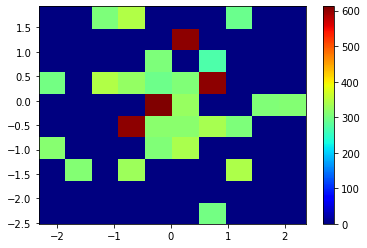

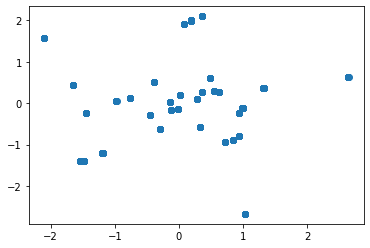

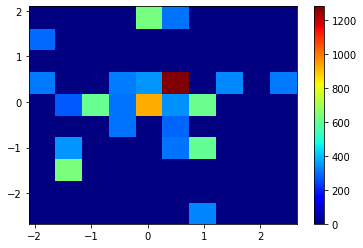

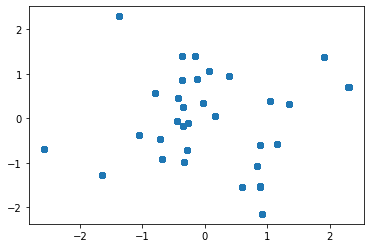

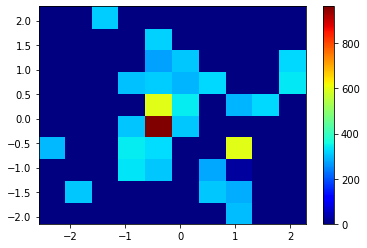

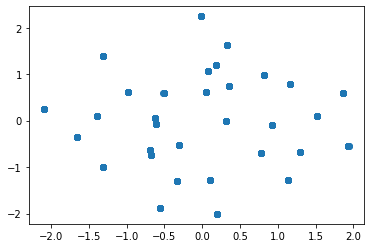

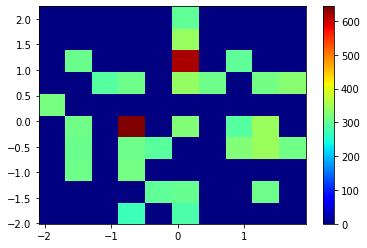

In [14]:
import matplotlib.pyplot as plt
encoded_message = encoder.predict(training_input_message_one_hot)
channel_in_array = numpy.transpose(encoded_message)
for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

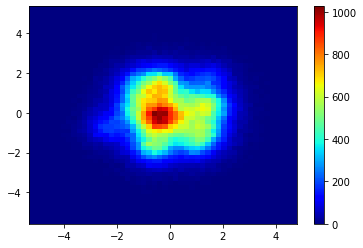

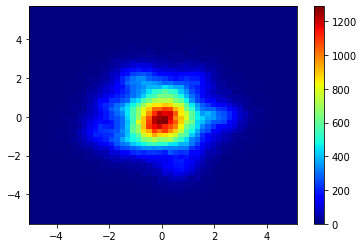

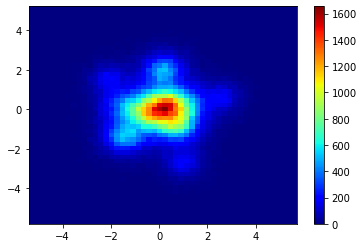

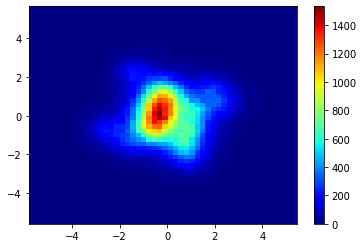

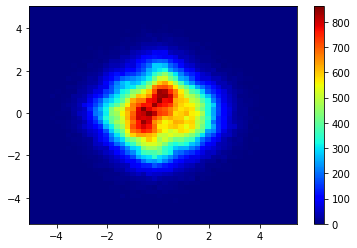

In [15]:
channel_out_array = numpy.transpose(channel_out1)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

Text(0, 0.5, 'Loss')

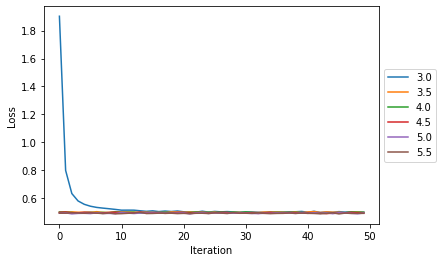

In [16]:
for snr in (numpy.arange (TRAIN_SNR_BEGIN, TRAIN_SNR_END, SNR_STEP_SIZE)):
  plt.plot(training_history1[snr].history['loss'], label=snr)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel ("Iteration")
plt.ylabel ("Loss")

In [17]:
test_input_message = numpy.random.randint(2**input_block_length, size=(int(NUM_OF_INPUT_MESSAGE_TEST),num_of_input_block,1))
#print(test_input_message)
test_input_message_one_hot = to_categorical(y=test_input_message, num_classes=2**input_block_length)
#print(test_input_message_one_hot)

In [18]:
print (test_input_message_one_hot.shape)
ber_per_iter_dl_tensor2, bler_per_iter_dl_tensor2, channel_out2  = get_block_onehot_ber_bler_of_model (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE), 
          encoder, decoder, 
          test_input_message_one_hot, 
          test_input_message, 
          test_input_message_one_hot.shape[0], test_input_message_one_hot.shape[1],
          int(numpy.math.log2(test_input_message_one_hot.shape[2])),
          channel_size*num_of_input_block)
print (ber_per_iter_dl_tensor2)
print (bler_per_iter_dl_tensor2)

(1000, 20, 32)
get_block_onehot_ber_bler_of_model
num_of_input: 1000  num_of_input_block: 20  input_block_length: 5 channel_size: 100
SNR: 0.000:-> BLER: 0.98700 BER: 0.09533 
total_bit_error: 9533
total_msg_error: 987
SNR: 0.500:-> BLER: 0.95900 BER: 0.07735 
total_bit_error: 7735
total_msg_error: 959
SNR: 1.000:-> BLER: 0.93000 BER: 0.05978 
total_bit_error: 5978
total_msg_error: 930
SNR: 1.500:-> BLER: 0.83400 BER: 0.04431 
total_bit_error: 4431
total_msg_error: 834
SNR: 2.000:-> BLER: 0.70700 BER: 0.03067 
total_bit_error: 3067
total_msg_error: 707
SNR: 2.500:-> BLER: 0.54800 BER: 0.02094 
total_bit_error: 2094
total_msg_error: 548
SNR: 3.000:-> BLER: 0.42600 BER: 0.01421 
total_bit_error: 1421
total_msg_error: 426
SNR: 3.500:-> BLER: 0.28300 BER: 0.00821 
total_bit_error: 821
total_msg_error: 283
SNR: 4.000:-> BLER: 0.16000 BER: 0.00444 
total_bit_error: 444
total_msg_error: 160
SNR: 4.500:-> BLER: 0.08100 BER: 0.00221 
total_bit_error: 221
total_msg_error: 81
SNR: 5.000:-> BLER: 

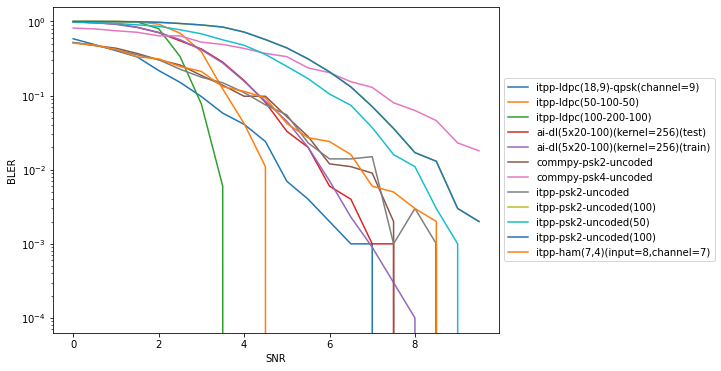

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_50_100_itpp_psk_4,'', label="itpp-ldpc(50-100-50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_100_200_itpp_psk_4[5:25],'', label="itpp-ldpc(100-200-100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_dl_tensor2,'', label="ai-dl(5x20-100)(kernel=256)(test)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_dl_tensor1,'', label="ai-dl(5x20-100)(kernel=256)(train)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_2,'', label="itpp-psk2-uncoded(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_2,'', label="itpp-psk2-uncoded(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_2,'', label="itpp-psk2-uncoded(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_xlabel('SNR')
#ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
#plt.legend ()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

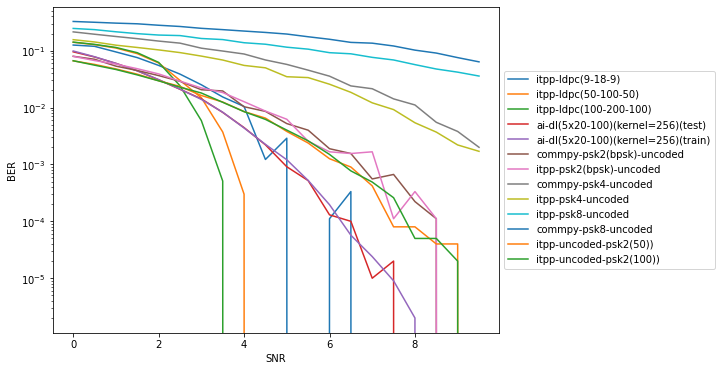

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(9-18-9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ldpc_50_100_itpp_psk_4[5:25],'', label="itpp-ldpc(50-100-50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ldpc_100_200_itpp_psk_4[5:25],'', label="itpp-ldpc(100-200-100)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor2,'', label="ai-dl(5x20-100)(kernel=256)(test)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor1,'', label="ai-dl(5x20-100)(kernel=256)(train)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2(bpsk)-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2(bpsk)-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="itpp-psk4-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_8,'', label="itpp-psk8-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_8,'', label="commpy-psk8-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_itpp_psk_2[5:25],'', label="itpp-uncoded-psk2(50))") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_itpp_psk_2[5:25],'', label="itpp-uncoded-psk2(100))") # plot BER vs SNR
#ax1.semilogy(snrs,PSK_2_BER_theory[0:20],'', label="psk2-theory") # plot BER vs SNR
#ax1.semilogy(snrs,PSK_4_BER_theory[0:20],'', label="psk4-theory") # plot BER vs SNR
#ax1.semilogy(snrs,PSK_8_BER_theory[0:20],'', label="psk8-theory") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_xlabel('SNR')
#ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
#plt.legend ()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
print ("ber_per_iter_dl_tensor=[",','.join(str(x) for x in ber_per_iter_dl_tensor), "]")
print ("ber_per_iter_dl_tensor1=[",','.join(str(x) for x in ber_per_iter_dl_tensor1), "]")
print ("ber_per_iter_dl_tensor2=[",','.join(str(x) for x in ber_per_iter_dl_tensor2), "]")
print ("bler_per_iter_dl_tensor=[",','.join(str(x) for x in bler_per_iter_dl_tensor), "]")
print ("bler_per_iter_dl_tensor1=[",','.join(str(x) for x in bler_per_iter_dl_tensor1), "]")
print ("bler_per_iter_dl_tensor2=[",','.join(str(x) for x in bler_per_iter_dl_tensor2), "]")

ber_per_iter_dl_tensor=[ 0.098627,0.078139,0.059442,0.043765,0.030999,0.021311,0.013458,0.008193,0.004456,0.002324,0.00103,0.000454,0.000182,6.9e-05,2.3e-05,9e-06,0.0,0.0,0.0,0.0 ]
ber_per_iter_dl_tensor1=[ 0.098612,0.078133,0.059702,0.044163,0.031014,0.021083,0.013892,0.008283,0.004369,0.002253,0.001207,0.000523,0.000196,5.7e-05,2.4e-05,9e-06,2e-06,0.0,0.0,0.0 ]
ber_per_iter_dl_tensor2=[ 0.09533,0.07735,0.05978,0.04431,0.03067,0.02094,0.01421,0.00821,0.00444,0.00221,0.00091,0.00052,0.00013,0.0001,1e-05,2e-05,0.0,0.0,0.0,0.0 ]
bler_per_iter_dl_tensor=[ 0.9855,0.9637,0.9144,0.8338,0.7025,0.5659,0.4103,0.2677,0.1609,0.0869,0.0392,0.0172,0.007,0.0027,0.001,0.0003,0.0,0.0,0.0,0.0 ]
bler_per_iter_dl_tensor1=[ 0.9868,0.9613,0.9123,0.8315,0.7117,0.5694,0.4162,0.2751,0.1564,0.0839,0.0452,0.02,0.0071,0.0023,0.0009,0.0003,0.0001,0.0,0.0,0.0 ]
bler_per_iter_dl_tensor2=[ 0.987,0.959,0.93,0.834,0.707,0.548,0.426,0.283,0.16,0.081,0.033,0.02,0.006,0.004,0.001,0.001,0.0,0.0,0.0,0.0 ]
